In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import jsonlines
from tqdm.auto import tqdm

def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    out_df = pd.DataFrame(lines)
    out_df["date"] = pd.to_datetime(out_df["date"].astype(int), unit="s")
    return out_df

all_shaders20k = load_data("./data/annotated")
all_api = load_data("./data/annotated/api")
df = pd.concat([all_shaders20k, all_api])
len(df)

27857

In [3]:
from filter import expand_functions
funcs = expand_functions(df)
len(funcs)

202752

In [4]:
funcs["header"].nunique() # 78256
funcs["id"].nunique() # 27857
# header_matrix = pd.crosstab(funcs['id'][:100], funcs['header'][:100])

27428

In [29]:
# Alternative 2: If you need to manually construct it
shader_ids = funcs['id'].unique()
function_headers = funcs['header'].unique()

# Create empty matrix
header_matrix = pd.DataFrame(
    0, 
    index=shader_ids,
    columns=function_headers
)

# Fill the matrix
for _, row in tqdm(funcs.iterrows(), total=len(funcs)):
    header_matrix.loc[row['id'], row['header']] = 1

  0%|          | 0/202752 [00:00<?, ?it/s]

In [32]:
# some clean up
print(header_matrix.sum(axis=0).value_counts().sort_index()[1:].sum()) # only 20380 functions that show up in multiple shaders!
header_matrix.drop(columns=header_matrix.columns[header_matrix.sum(axis=0) <= 2], inplace=True) # drop functions that don't coocur anyway
header_matrix.drop(index=header_matrix.index[header_matrix.sum(axis=1) <= 1], inplace=True) # drop shaders that only have a single function (main function)
header_matrix.drop(columns=header_matrix.columns[header_matrix.columns.str.startswith("void mainImage")], inplace=True)
print(header_matrix.shape)
# convert to uint8 matrix for space efficiency
header_matrix = header_matrix.astype(np.uint8)
# memory footprint
header_matrix.memory_usage().sum()

20380
(16155, 10071)


162826245

In [33]:
import scipy.sparse as sp

# Convert to sparse matrix
sparse_header = sp.csr_matrix(header_matrix.values)

# Perform the multiplication using sparse matrices
sparse_shared = sparse_header @ sparse_header.T

# Convert back to pandas if needed
shared_functions = pd.DataFrame(
    sparse_shared.toarray(), 
    index=header_matrix.index,
    columns=header_matrix.index
)

In [201]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

G = nx.from_pandas_adjacency(shared_functions)
G.remove_edges_from(nx.selfloop_edges(G))

In [202]:
# Find largest connected component (if graph is fragmented)
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()
print(f"Largest component has {G_largest.number_of_nodes()} nodes and {G_largest.number_of_edges()} edges")# Basic network stats
print("Network statistics:")
print(f"Number of connected components: {nx.number_connected_components(G)}")
# print(f"Average clustering coefficient: {nx.average_clustering(G)}")
# print(f"Average path length: {nx.average_shortest_path_length(G_largest)}")  # Only on largest component

# Find most central nodes (shaders that share functions with many others)
centrality = nx.degree_centrality(G)
top_shaders = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nMost connected shaders:")
for shader, score in top_shaders:
    print(f"Shader {shader}: connected to {score:.4f} of network")

Largest component has 15194 nodes and 1614290 edges
Network statistics:
Number of connected components: 243

Most connected shaders:
Shader fdlGWM: connected to 0.1054 of network
Shader 3ssBWH: connected to 0.1040 of network
Shader Xd3fWr: connected to 0.1028 of network
Shader XsjfDG: connected to 0.1011 of network
Shader WtjGRw: connected to 0.1008 of network
Shader MljXzw: connected to 0.1002 of network
Shader 3tyGWz: connected to 0.1002 of network
Shader XtGGR3: connected to 0.0992 of network
Shader Xt2yzt: connected to 0.0970 of network
Shader Xl3Szj: connected to 0.0969 of network


In [203]:
list(G.edges)[:10]

[('4dB3DV', '4sj3Wd'),
 ('4dB3DV', 'MdjGWt'),
 ('4dB3DV', '4sXXz7'),
 ('4dB3DV', '4dfSD4'),
 ('4dB3DV', 'ldfSDN'),
 ('4dB3DV', 'MdfXWr'),
 ('4dB3DV', 'MsXSDN'),
 ('4dB3DV', 'MsfXW7'),
 ('4dB3DV', 'ldlSRs'),
 ('4dB3DV', 'ldBXDG')]

In [381]:
# find a smaller subgraph
def get_subgraph(G, min_size=5, max_size=220):
    for sg in nx.connected_components(G):
        if len(sg) > min_size and len(sg) < max_size:
            yield G.subgraph(sg)
        else:
            continue
    return None

subgraph_gen = get_subgraph(G)

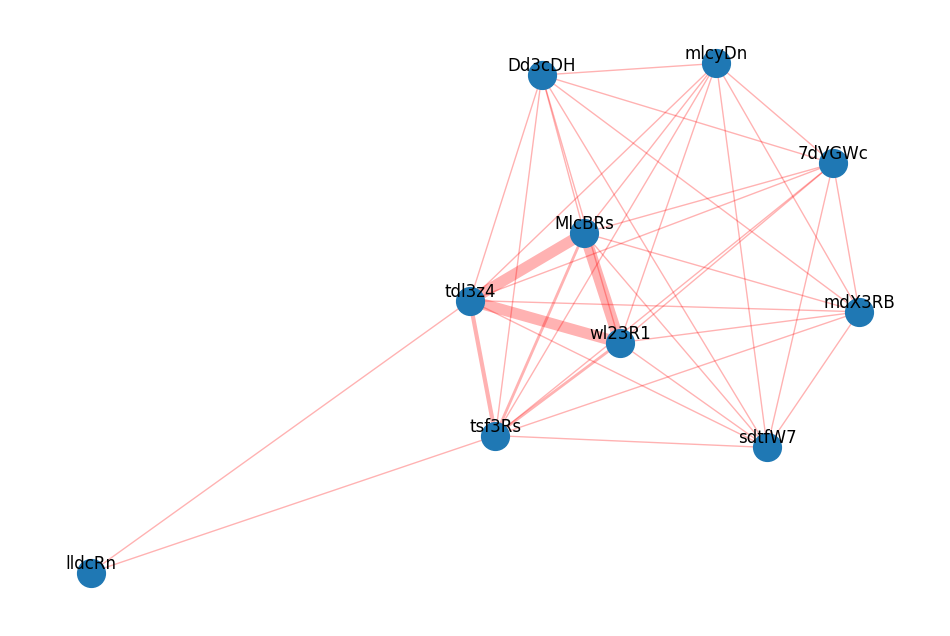

In [392]:
subgraph = next(subgraph_gen)

# add direction by comparing publishing date of shaders
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)
weights = [shared_functions[u][v] for u, v in subgraph.edges]
nx.draw_networkx_edges(subgraph, pos, alpha=0.3, width=weights, edge_color="red")
nx.draw_networkx_nodes(subgraph, pos, node_size=400)
nx.draw_networkx_labels(subgraph, pos, font_size=12, verticalalignment="bottom")
plt.axis("off")
plt.show()